# What is different about this notebook?

This notebook is essentially the more advanced version of the original neural network model training notebook. 
There are several motivations for this model.
1. Capability of modeling ion flux. To do this, I had to include Lyman Alpha emissions 
2. Capability of modeling mean eletron and ion energy flux. 
3. Capability of including geomagnetic indices as inputs

In [1]:
import numpy as np
import h5py 
import os
from tensorflow import keras
import pdb
import glob
import pandas as pd
from geospacepy import special_datetime

# Import the Conjunction Data

In [2]:
hd_dir = os.path.join('/home/matsuo/amgeo_dev/LBH_to_eflux/LBH_to_eflux/','conjunction_data')
file_dir = os.path.join(hd_dir,'*.hdf5')
conjunc_files = glob.glob(file_dir)
conjunc_files = np.sort(conjunc_files) #sort the files by time 

ele_diff_energy_flux_arr,ion_diff_energy_flux_arr = np.empty((0,19)) ,np.empty((0,19))
ele_flux, ion_flux = [],[]
ele_mean, ion_mean = [],[]
ssusi_lbhl, ssusi_lbhs, ssusi_lyman = [],[], []
jds, lons, lats = [], [], []
sat_nums, passes, hemis = [], [], []

for file_name in conjunc_files:
    with h5py.File(file_name, 'r') as f:
        jds.extend(f['jds'][:])
        passes.extend(f['pass_num'][:])
        sat_nums.extend(f['sat_no'][:])
        lons.extend(f['lons'][:])
        lats.extend(f['lats'][:])
#         hemis.extend(f['hemi'][:])
        #input data
        ssusi_lbhl.extend(f['LBHL_interped'][:])
        ssusi_lbhs.extend(f['LBHS_interped'][:])
        ssusi_lyman.extend(f['LYMAN_interped'][:])
        #output 

        ele_flux.extend(f['ele_total_energy_flux'][:])
        ion_flux.extend(f['ion_total_energy_flux'][:])
        
        ele_mean.extend(f['ele_mean_energy'][:])
        ion_mean.extend(f['ion_mean_energy'][:])


In [3]:
d = {'jds': jds, 'passes': passes, 'sat_nums' : sat_nums, 'lons' : lons, 'lats' : lats, 
     'lbhl' : ssusi_lbhl,'lbhs' : ssusi_lbhs, 'lyman' : ssusi_lyman,
    'ion_total_flux' : ion_flux, 'ele_total_flux' : ele_flux,
    'ion_mean_flux' : ion_mean, 'ele_mean_flux' : ele_mean}
df = pd.DataFrame(data=d)

In [4]:
df

,jds,passes,sat_nums,lons,lats,lbhl,lbhs,lyman,ion_total_flux,ele_total_flux,ion_mean_flux,ele_mean_flux
0,2.456706e+06,0.0,16.0,231.770668,53.202229,0.009499,0.000000,0.000000,0.000000,0.000269,NaN,0.073032
1,2.456706e+06,0.0,16.0,231.737165,53.251019,0.019473,0.000000,0.000000,0.000000,0.000537,NaN,0.053419
2,2.456706e+06,0.0,16.0,231.703792,53.299797,0.019733,0.000000,0.000000,0.000217,0.000935,0.792410,0.062845
3,2.456706e+06,0.0,16.0,231.670303,53.348572,0.019949,0.000000,0.000000,0.000000,0.000952,NaN,0.063960
4,2.456706e+06,0.0,16.0,231.636772,53.397343,0.020081,0.000000,0.000000,0.000033,0.000724,0.204000,0.087637
...,...,...,...,...,...,...,...,...,...,...,...,...
794694,2.456712e+06,573.0,18.0,86.537905,72.834541,0.401199,0.152352,0.152352,0.208207,0.275547,12.014087,1.164826
794695,2.456712e+06,573.0,18.0,86.430416,72.885139,0.401696,0.152388,0.152388,0.123890,0.339790,11.253605,0.997523
794696,2.456712e+06,573.0,18.0,86.322212,72.935677,0.402138,0.152418,0.152418,0.146877,0.310970,11.767205,1.177323
794697,2.456712e+06,573.0,18.0,86.213379,72.986191,0.402532,0.152440,0.152440,0.148024,0.320669,10.481705,1.000869


In [5]:
enddt = special_datetime.jd2datetime(np.nanmax(df['jds']))
startdt = special_datetime.jd2datetime(np.nanmin(df['jds']))

In [6]:
unique_passes = np.unique(df['passes'])

# Feature Engineering

## Geomagnetic Indices Features

### Get IMF components and useful activity indices

For this I use a useful tool by Liam Kilcommons that allows you to autodownload NASA omniweb data.

In [7]:
from nasaomnireader import omnireader 

Traceback (most recent call last):
  File "/home/matsuo/amgeo_dev/AMGeO/src/nasaomnireader/nasaomnireader/__init__.py", line 5, in <module>
    from nasaomnireader.omnireader_config import config
ModuleNotFoundError: No module named 'nasaomnireader.omnireader_config'

Solar wind data files will be saved to /home/matsuo/.local/share/nasaomnireader


In [8]:
def download_omni_data(startdt,enddt,indices):
    omni_data = {}
    freq = '5min'
    omniInt = omnireader.omni_interval(startdt,enddt,freq)
    jd_arr = special_datetime.datetimearr2jd(omniInt['Epoch'])
    for index in indices:
        omni_data[index] = omniInt[index] 
    return jd_arr,omni_data

indices =['BY_GSM','BZ_GSM','AE_INDEX','AL_INDEX']
jd_arr, omni_data = download_omni_data(startdt,enddt,indices)
omni_data['jd_index'] = jd_arr
df_index = pd.DataFrame(data = omni_data)

Created interval between 2014-02-17 and 2014-02-23, cadence 5min, start index 4610, end index 6624


In [9]:
df_index.head()

,BY_GSM,BZ_GSM,AE_INDEX,AL_INDEX,jd_index
0,7.64,-1.39,35,-20,2.456706e+06
1,7.69,-1.47,41,-16,2.456706e+06
2,7.23,-1.11,51,-21,2.456706e+06
3,7.35,-1.16,60,-24,2.456706e+06
4,6.78,-2.80,75,-29,2.456706e+06


### Interpolate observations 

Now I need to interpolate these index values to the observation times. To do this, I'll use nearest neighbors.

In [10]:
from sklearn.neighbors import NearestNeighbors
tol = 10/1440 #tolerance of 10 minutes
model = NearestNeighbors(n_neighbors = 1, radius = tol)
model.fit(jd_arr.reshape(-1,1))
neighbors = model.kneighbors(df['jds'].to_numpy().reshape(-1,1))
neighbor_index = neighbors[1]

Include the time interpolated features in the mean dataframe

In [11]:
for index in indices:
    df[index] = omni_data[index][neighbor_index]

Check if that worked

In [12]:
df.head()

,jds,passes,sat_nums,lons,lats,lbhl,lbhs,lyman,ion_total_flux,ele_total_flux,ion_mean_flux,ele_mean_flux,BY_GSM,BZ_GSM,AE_INDEX,AL_INDEX
0,2.456706e+06,0.0,16.0,231.770668,53.202229,0.009499,0.0,0.0,0.000000,0.000269,NaN,0.073032,7.64,-1.39,35,-20
1,2.456706e+06,0.0,16.0,231.737165,53.251019,0.019473,0.0,0.0,0.000000,0.000537,NaN,0.053419,7.64,-1.39,35,-20
2,2.456706e+06,0.0,16.0,231.703792,53.299797,0.019733,0.0,0.0,0.000217,0.000935,0.79241,0.062845,7.64,-1.39,35,-20
3,2.456706e+06,0.0,16.0,231.670303,53.348572,0.019949,0.0,0.0,0.000000,0.000952,NaN,0.063960,7.64,-1.39,35,-20
4,2.456706e+06,0.0,16.0,231.636772,53.397343,0.020081,0.0,0.0,0.000033,0.000724,0.20400,0.087637,7.64,-1.39,35,-20


## Smoothing

Applying smoothing to the time series helps reduce noise

In [13]:
columns_to_smooth = ['ion_total_flux','ele_total_flux','ion_mean_flux','ele_mean_flux']
for column_to_smooth in columns_to_smooth:
    df[column_to_smooth+'_smoothed'] = df[column_to_smooth].rolling(10, center = True).mean().fillna(method='bfill').fillna(method='ffill')

In [14]:
df.head()

,jds,passes,sat_nums,lons,lats,lbhl,lbhs,lyman,ion_total_flux,ele_total_flux,ion_mean_flux,ele_mean_flux,BY_GSM,BZ_GSM,AE_INDEX,AL_INDEX,ion_total_flux_smoothed,ele_total_flux_smoothed,ion_mean_flux_smoothed,ele_mean_flux_smoothed
0,2.456706e+06,0.0,16.0,231.770668,53.202229,0.009499,0.0,0.0,0.000000,0.000269,NaN,0.073032,7.64,-1.39,35,-20,0.000029,0.000738,13.193297,0.066146
1,2.456706e+06,0.0,16.0,231.737165,53.251019,0.019473,0.0,0.0,0.000000,0.000537,NaN,0.053419,7.64,-1.39,35,-20,0.000029,0.000738,13.193297,0.066146
2,2.456706e+06,0.0,16.0,231.703792,53.299797,0.019733,0.0,0.0,0.000217,0.000935,0.79241,0.062845,7.64,-1.39,35,-20,0.000029,0.000738,13.193297,0.066146
3,2.456706e+06,0.0,16.0,231.670303,53.348572,0.019949,0.0,0.0,0.000000,0.000952,NaN,0.063960,7.64,-1.39,35,-20,0.000029,0.000738,13.193297,0.066146
4,2.456706e+06,0.0,16.0,231.636772,53.397343,0.020081,0.0,0.0,0.000033,0.000724,0.20400,0.087637,7.64,-1.39,35,-20,0.000029,0.000738,13.193297,0.066146


## Get rid of nan rows 

In [15]:
df = df.dropna()

## Separate input and outputs

Before I continue, I'll separate what will be neural network inputs and what wont be. For this notebook, I've decided to predict electron total energy flux but this can easily be changed.

In [16]:
# df_inputs = df[['lbhl','lbhs','lyman','AE_INDEX','AL_INDEX','BZ_GSM','BY_GSM','ion_total_flux_smoothed','ion_mean_flux_smoothed']]
# df_inputs = df[['lbhl','lbhs','lyman','AE_INDEX','AL_INDEX','BZ_GSM','BY_GSM','ele_total_flux_smoothed','ion_total_flux_smoothed', 'ele_mean_flux_smoothed', 'ion_mean_flux_smoothed']]
df_inputs = df[['lbhl','lbhs','lyman','ion_total_flux_smoothed','ion_mean_flux_smoothed']]

# df_outputs = df[ ['ele_total_flux_smoothed','ion_total_flux_smoothed', 'ele_mean_flux_smoothed', 'ion_mean_flux_smoothed']]
df_outputs = df[ ['ele_total_flux_smoothed']]

In [17]:
df_inputs.head()

,lbhl,lbhs,lyman,ion_total_flux_smoothed,ion_mean_flux_smoothed
2,0.019733,0.0,0.0,0.000029,13.193297
4,0.020081,0.0,0.0,0.000029,13.193297
8,0.018192,0.0,0.0,0.000007,13.193297
14,0.009418,0.0,0.0,0.000003,13.193297
24,0.003213,0.0,0.0,0.000008,13.193297


## Scaling and Normalizing

To speed up training, we will scale and normalize the input and output data using the RobustScaler from scikit learn. This is just an InterQuartile normalizer that's a little more robust to outliers. 

In [18]:
from sklearn.preprocessing import RobustScaler

scaler_y = RobustScaler()
scaler_x = RobustScaler()

scaler_x.fit(df_inputs)
scaler_y.fit(df_outputs)

X = scaler_x.transform(df_inputs)
y = scaler_y.transform(df_outputs)

Save the scalers

In [19]:
import pickle
pickle.dump(scaler_x, open('X_scaler_ion.pkl','wb'))
pickle.dump(scaler_y, open('Y_scaler_ion.pkl','wb'))

Save the data

In [20]:
h5_filename = 'model_inputs_ion.h5'
h5f = h5py.File(h5_filename,'w')
h5f.create_dataset('X',data = X)
h5f.create_dataset('y',data = y)
h5f.close()

df.to_hdf(h5_filename, key ='df')


## Model Structure

In [21]:
def get_model(n_inputs, n_outputs):
    
    inputs = keras.Input(shape=(n_inputs))
    first_layer = keras.layers.Dense(20, kernel_initializer='normal',activation = 'relu', bias_regularizer=keras.regularizers.l2(1e-4), activity_regularizer= keras.regularizers.l2(1e-5))(inputs)
    second_layer = keras.layers.LeakyReLU(20)(first_layer)
#     third_layer = keras.layers.LeakyReLU(8)(second_layer)
    outputs = keras.layers.Dense(n_outputs, activation ='relu',
                                 bias_regularizer=keras.regularizers.l2(1e-4), activity_regularizer=keras.regularizers.l2(1e-5))(second_layer)
    
    model = keras.Model(inputs = inputs, outputs = outputs)
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    loss = [keras.losses.MeanSquaredError()]
    # Compile the network :
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse','mean_absolute_percentage_error'])

    return model


In [22]:
model = get_model(len(df_inputs.columns),len(df_outputs.columns))

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                120       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


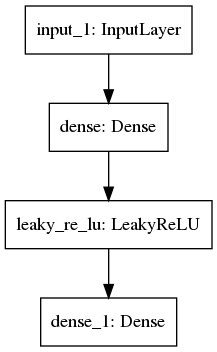

In [24]:
keras.utils.plot_model(model, "my_first_model.png")


Model Training with K folds Cross Val

# Fit the Model

## Test Train Split

In [25]:
# let 15% of passes be test passes
test_ratio = 0.15
num_test_passes = int(test_ratio * len(unique_passes) ) - 1
#pick random passes to be test passes
num_test_pass = np.random.choice(unique_passes, num_test_passes, replace=False) 
test_mask = np.zeros_like(df['passes'], dtype = bool)
for test_pass_num in num_test_pass:
    test_mask = np.logical_or(test_mask, df['passes'] == test_pass_num)
train_mask = np.logical_not(test_mask)

In [26]:
h5_filename = 'model_inputs_ion.h5'
h5f = h5py.File(h5_filename,'a')
h5f.create_dataset('test_passes',data = num_test_pass)
h5f.create_dataset('test_mask',data=test_mask)
h5f.close()

In [27]:
y_test, y_train = y[test_mask], y[train_mask]
X_test, X_train = X[test_mask], X[train_mask]

In [28]:
callback = keras.callbacks.EarlyStopping(monitor = 'loss', patience = 50,restore_best_weights = True)
history = model.fit(X, y, epochs=500, batch_size=32, validation_split = 0.2, callbacks = [callback])


Epoch 1/500
6753/6753 [==============================] - 5s 700us/step - loss: 2.8903 - mse: 2.8900 - mean_absolute_percentage_error: 2457.8157 - val_loss: 5.3153 - val_mse: 5.3150 - val_mean_absolute_percentage_error: 407.4099
Epoch 2/500
6753/6753 [==============================] - 5s 670us/step - loss: 2.7352 - mse: 2.7347 - mean_absolute_percentage_error: 3310.6921 - val_loss: 4.9519 - val_mse: 4.9514 - val_mean_absolute_percentage_error: 335.5291
Epoch 3/500
6753/6753 [==============================] - 5s 692us/step - loss: 2.6645 - mse: 2.6638 - mean_absolute_percentage_error: 2972.0471 - val_loss: 5.9149 - val_mse: 5.9143 - val_mean_absolute_percentage_error: 272.8632
Epoch 4/500
6753/6753 [==============================] - 5s 707us/step - loss: 2.5996 - mse: 2.5987 - mean_absolute_percentage_error: 3128.2771 - val_loss: 5.4086 - val_mse: 5.4078 - val_mean_absolute_percentage_error: 319.0544
Epoch 5/500
6753/6753 [==============================] - 5s 692us/step - loss: 2.5492 - 

In [29]:
model.save('ele_flux_with_ion')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ele_flux_with_ion/assets
